In [1]:

# BRING IN LIBRARIES
import pandas as pd
import os
from dotenv import load_dotenv
from pandasai import SmartDataframe
from pandasai.llm import BambooLLM
from langchain_groq.chat_models import ChatGroq
from pandasai.connectors import PandasConnector
from pandasai.skills import skill
from pandasai import Agent
from pandasai.ee.vectorstores import ChromaDB
from dotenv import load_dotenv
load_dotenv()
import pandasai as pai
pai.clear_cache()

c:\Users\j.mundondo\OneDrive - Statsports\Desktop\statsportsdoc\Projects\frequency_chat_PH\footydata\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
df = pd.read_csv(r"C:\Users\j.mundondo\OneDrive - Statsports\Desktop\statsportsdoc\Projects\frequency_chat_PH\data\individual_efforts\david_only_metrics.csv")


In [3]:
# SET UP LLM
llm_api_key = os.environ['GROQ_API_KEY']
langchain_api_key = os.environ['LANGCHAIN_API_KEY']
llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
#    seed=5
)
# Field descriptions
field_descriptions = {
    'High Intensity Activity Type': 'Classification of the movement (Acceleration/Deceleration/Sprint)',
    'Start Time': 'Timestamp when activity began (HH:MM:SS)',
    'End Time': 'Timestamp when activity ended (HH:MM:SS)', 
    'Time Since Last': 'Duration since previous activity of that same type (MM:SS.S)',
    'Duration': 'Length of activity (MM:SS.S)',
    'Distance': 'Meters traveled during activity',
    'Magnitude': 'Peak intensity measure of the activity',
    'Avg Metabolic Power': 'Average energy expenditure during activity (W/kg)',
    'Dynamic Stress Load': 'Cumulative stress metric from activity intensity',
    'Duration_seconds': 'The number of seconds the High Intensity Activity Type in the row lasted as a float',
    'Long_sprint': 'A binary flag indicating if a movement is a long sprint. 1 indicates it is a long sprint, 0 means it is not.',
    'Preceding High Intensity Activity Type': 'The type of high intensity activity type that happened before this row.'
}

# Update agent setup to include new skill
vector_store = ChromaDB()
agent = Agent(df, 
             vectorstore=vector_store,
             memory_size=2,
             config={
                "field_descriptions": field_descriptions,
                'llm': llm,
                "verbose": True,
                "custom_whitelisted_dependencies": ["dateutil", "matplotlib", "seaborn"]
             })

In [4]:
# Define skills
@skill
def calculate_time_between_actions(df, action):
    """
    Calculates the average time between specified actions using datetime calculations.
    This skill should be used for any questions about:
    - Average time between specific activities (sprints, accelerations, decelerations)
    - Time intervals between movements
    - Temporal spacing of activities
    - Mean duration between consecutive actions
    
    Args:
        df (pandas.DataFrame): DataFrame containing player actions with columns:
            - 'High Intensity Activity Type': The type of movement
            - 'Start Time': Timestamp of when the activity began
        action (str): The type of action to analyze. Must be one of:
            - 'Sprint'
            - 'Acceleration' 
            - 'Deceleration'
    
    Returns:
        dict: Dictionary containing:
            - type: 'number'
            - value: Average time in seconds between consecutive actions
    
    Example queries this skill should handle:
    - "What's the average time between sprints?"
    - "How long do players typically wait between accelerations?"
    - "What's the mean time interval between consecutive decelerations?"
    - "Calculate the average duration between sprint efforts"
    """
    try:
        action_df = df[df['High Intensity Activity Type'] == action].copy()
        
        if len(action_df) < 2:
            return {'type': 'number', 'value': 0.0}
            
        action_df['Start Time'] = pd.to_datetime(action_df['Start Time'])
        action_df = action_df.sort_values('Start Time')
        
        time_diffs = (action_df['Start Time'] - action_df['Start Time'].shift(1)).dropna()
        time_diffs_seconds = time_diffs.dt.total_seconds()
        time_diffs_seconds = time_diffs_seconds[time_diffs_seconds > 0]
        
        if len(time_diffs_seconds) > 0:
            average_time = round(time_diffs_seconds.mean(), 2)
            return {
                'type': 'number',
                'value': float(average_time)
            }
        else:
            return {
                'type': 'number',
                'value': 0.0
            }
            
    except Exception as e:
        print(f"Error: {str(e)}")
        return {
            'type': 'number',
            'value': 0.0
        }

@skill
def find_multiple_actions_in_timespan(df, action, time_in_seconds):
    """
    Identifies occurrences of multiple actions occurring within a specified timespan.
    This skill should be used for any questions about:
    - Frequency of repeated actions within a time window
    - Clusters of activities
    - Multiple efforts in quick succession
    - Action density in time periods
    
    Args:
        df (pandas.DataFrame): DataFrame containing player actions
        action (str): The type of action to analyze. Must be one of:
            - 'Sprint'
            - 'Acceleration'
            - 'Deceleration'
        time_in_seconds (int): Time window to analyze in seconds
    
    Returns:
        dict: Dictionary containing:
            - type: 'number'
            - value: Count of time windows containing multiple actions
    
    Example queries this skill should handle:
    - "How many times were there multiple sprints within 30 seconds?"
    - "Count instances of repeated accelerations in 1 minute windows"
    - "Find clusters of decelerations happening within 45 seconds"
    - "Number of times a player did multiple sprints in quick succession"
    """
    df['Start Time'] = pd.to_datetime(df['Start Time'])
    
    action_df = df[df['High Intensity Activity Type'] == action].copy()
    action_df = action_df.sort_values('Start Time')
    
    windows = []
    current_window = []
    
    for idx, row in action_df.iterrows():
        current_time = row['Start Time']
        
        if not current_window:
            current_window = [(current_time, row)]
            continue
        
        time_diff = (current_time - current_window[0][0]).total_seconds()
        
        if time_diff <= time_in_seconds:
            current_window.append((current_time, row))
        else:
            if len(current_window) > 1:
                windows.append(current_window)
            current_window = [(current_time, row)]
    
    if len(current_window) > 1:
        windows.append(current_window)

    # Calculate statistics
    total_windows = len(windows)
    
    return {
        'type': 'number',
        'value': float(total_windows)
    }


# Add new plotting skill
#@skill 

@skill 
def plot_time_between_actions(df, action: str):
    """
    Displays histogram and box plot of time intervals between specific actions.
    
    Args:
        df (pandas.DataFrame): DataFrame containing player actions
        action (str): The type of action to analyze ('Sprint', 'Acceleration', 'Deceleration')
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Filter and prepare data
    action_df = df[df['High Intensity Activity Type'] == action].copy()
    action_df['Start Time'] = pd.to_datetime(action_df['Start Time'])
    action_df = action_df.sort_values('Start Time')
    
    # Calculate time differences
    time_diffs = (action_df['Start Time'] - action_df['Start Time'].shift(1)).dt.total_seconds()
    time_diffs = time_diffs[time_diffs > 0]
    
    # Create figure with two subplots
    plt.figure(figsize=(10, 8))
    
    # Histogram
    plt.subplot(2, 1, 1)
    sns.histplot(time_diffs, bins=30)
    plt.title(f'Distribution of Time Between {action}s')
    plt.xlabel('Seconds between actions')
    plt.ylabel('Frequency')
    
    # Box plot
    plt.subplot(2, 1, 2)
    sns.boxplot(x=time_diffs)
    plt.title(f'Box Plot of Time Between {action}s')
    plt.xlabel('Seconds between actions')
    
    # Add statistics
    stats_text = (f'Mean: {time_diffs.mean():.1f}s\n'
                 f'Median: {time_diffs.median():.1f}s\n'
                 f'Min: {time_diffs.min():.1f}s\n'
                 f'Max: {time_diffs.max():.1f}s')
    plt.figtext(0.95, 0.5, stats_text, fontsize=10, ha='right')
    
    plt.tight_layout()

agent.add_skills(calculate_time_between_actions, 
                find_multiple_actions_in_timespan,
                plot_time_between_actions)

In [5]:
training_queries = [
    "What is the average time between sprints?",
    "How much time passes between accelerations?",
    "What's the typical time between consecutive decelerations?",
    "Calculate the mean duration between sprint efforts",
    "How many times were there multiple sprints within 30 seconds?",
    "Count instances of repeated accelerations in 1 minute windows",
    "Find clusters of decelerations happening within 45 seconds",
    "How often did the player do multiple sprints in quick succession?",
    "What's the average rest period between sprints?",
    "How frequently do accelerations occur?",
    "Plot the distribution of times between sprints",
    "Show me a visualization of acceleration intervals"
]

training_responses = [
    "result = calculate_time_between_actions(dfs[0], 'Sprint')",
    "result = calculate_time_between_actions(dfs[0], 'Acceleration')",
    "result = calculate_time_between_actions(dfs[0], 'Deceleration')",
    "result = calculate_time_between_actions(dfs[0], 'Sprint')",
    "result = find_multiple_actions_in_timespan(dfs[0], 'Sprint', 30)",
    "result = find_multiple_actions_in_timespan(dfs[0], 'Acceleration', 60)",
    "result = find_multiple_actions_in_timespan(dfs[0], 'Deceleration', 45)",
    "result = find_multiple_actions_in_timespan(dfs[0], 'Sprint', 30)",
    "result = calculate_time_between_actions(dfs[0], 'Sprint')",
    "result = calculate_time_between_actions(dfs[0], 'Acceleration')",
    "result = plot_time_between_actions(dfs[0], 'Sprint')",
    "result = plot_time_between_actions(dfs[0], 'Acceleration')"
]

# Train the agent
agent.train(queries=training_queries, codes=training_responses)
print("done")

done


In [6]:
# Test the agent
response = agent.chat("What is the average time between sprints?")
print(response)


print(agent.last_code_generated)


{'type': 'number', 'value': 462.0}
462.0
# Import the required dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
dfs = [pd.DataFrame(...)]

# Calculate the average time between sprints
result = calculate_time_between_actions(dfs[0], 'Sprint')

# Declare the result variable
result = {"type": "number", "value": result["value"]}

print(result)


In [7]:
response2 = agent.chat("How many times were there multiple Decelerations within 1 minute?")
print(response2)


print(agent.last_code_generated)

{'type': 'number', 'value': 23.0}
23.0
# Import the required dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Define the functions
def calculate_time_between_actions(df, action):
    # Calculate the average time between specified actions using datetime calculations
    df['Start Time'] = pd.to_datetime(df['Start Time'])
    df['End Time'] = pd.to_datetime(df['End Time'])
    df['Time Since Last'] = pd.to_datetime(df['Time Since Last'])
    df['Duration_seconds'] = pd.to_datetime(df['Duration_seconds'])
    df['Long_sprint'] = pd.to_datetime(df['Long_sprint'])
    df['Preceding High Intensity Activity Type'] = pd.to_datetime(df['Preceding High Intensity Activity Type'])
    df['Time Since Last'] = (df['Start Time'] - df['Time Since Last']).dt.total_seconds()
    df = df[df['High Intensity Activity Type'] == action]
    avg_time = df['Time Since Last'].mean()
    return {'type': 'number', 'value': avg_time}

def find_multiple_actions_in_timespan(df, action, time_in_sec

{'type': 'number', 'value': 107.62}
107.62
# Import the required dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Define the function to calculate the average time between actions
def calculate_time_between_actions(df, action):
    """
    Calculates the average time between specified actions using datetime calculations.
    This skill should be used for any questions about:
    - Average time between specific activities (sprints, accelerations, decelerations)
    - Time intervals between movements
    - Temporal spacing of activities
    - Mean duration between consecutive actions
    
    Args:
        df (pandas.DataFrame): DataFrame containing player actions with columns:
            - 'High Intensity Activity Type': The type of movement
            - 'Start Time': Timestamp of when the activity began
        action (str): The type of action to analyze. Must be one of:
            - 'Sprint'
            - 'Acceleration' 
            - 'Deceleration'
    
    Retu

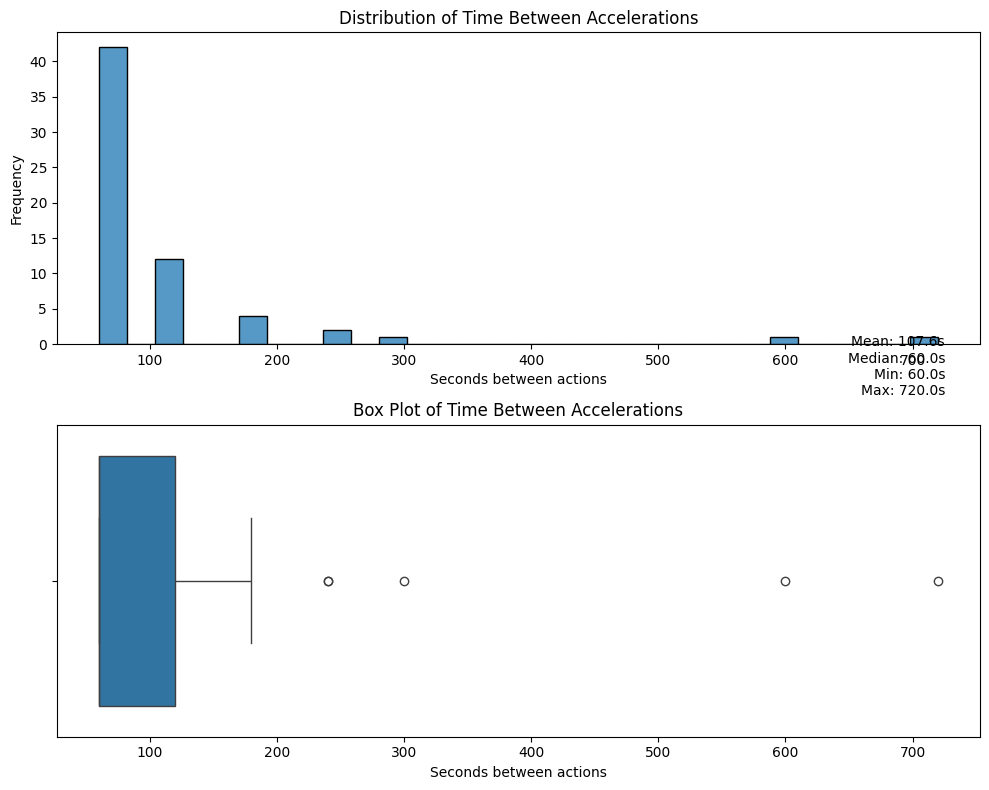

In [8]:
response = agent.chat("What is the average time between Accelerations?")
print(response)


print(agent.last_code_generated)

Traceback (most recent call last):
  File "c:\Users\j.mundondo\OneDrive - Statsports\Desktop\statsportsdoc\Projects\frequency_chat_PH\footydata\Lib\site-packages\dateutil\parser\_parser.py", line 649, in parse
    ret = self._build_naive(res, default)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\j.mundondo\OneDrive - Statsports\Desktop\statsportsdoc\Projects\frequency_chat_PH\footydata\Lib\site-packages\dateutil\parser\_parser.py", line 1235, in _build_naive
    naive = default.replace(**repl)
            ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: hour must be in 0..23

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "pandas\_libs\tslib.pyx", line 605, in pandas._libs.tslib.array_to_datetime
  File "pandas\_libs\tslibs\parsing.pyx", line 318, in pandas._libs.tslibs.parsing.parse_datetime_string
  File "c:\Users\j.mundondo\OneDrive - Statsports\Desktop\statsportsdoc\Projects\frequency_chat_PH\footydata\Lib\site-packa

Unfortunately, I was not able to answer your question, because of the following error:

hour must be in 0..23: 25:12.4 present at position 123

dfs[0]['Time Since Last'] = pd.to_datetime(dfs[0]['Time Since Last'])
dfs[0]['Time Between Sprints'] = (dfs[0]['Time Since Last'] - dfs[0]['Time Since Last'].shift()).fillna(pd.Timedelta(seconds=0))
dfs[0]['Time Between Sprints'] = dfs[0]['Time Between Sprints'].dt.total_seconds()
plt.hist(dfs[0]['Time Between Sprints'], bins=50)
plt.xlabel('Time Between Sprints (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Between Sprints')


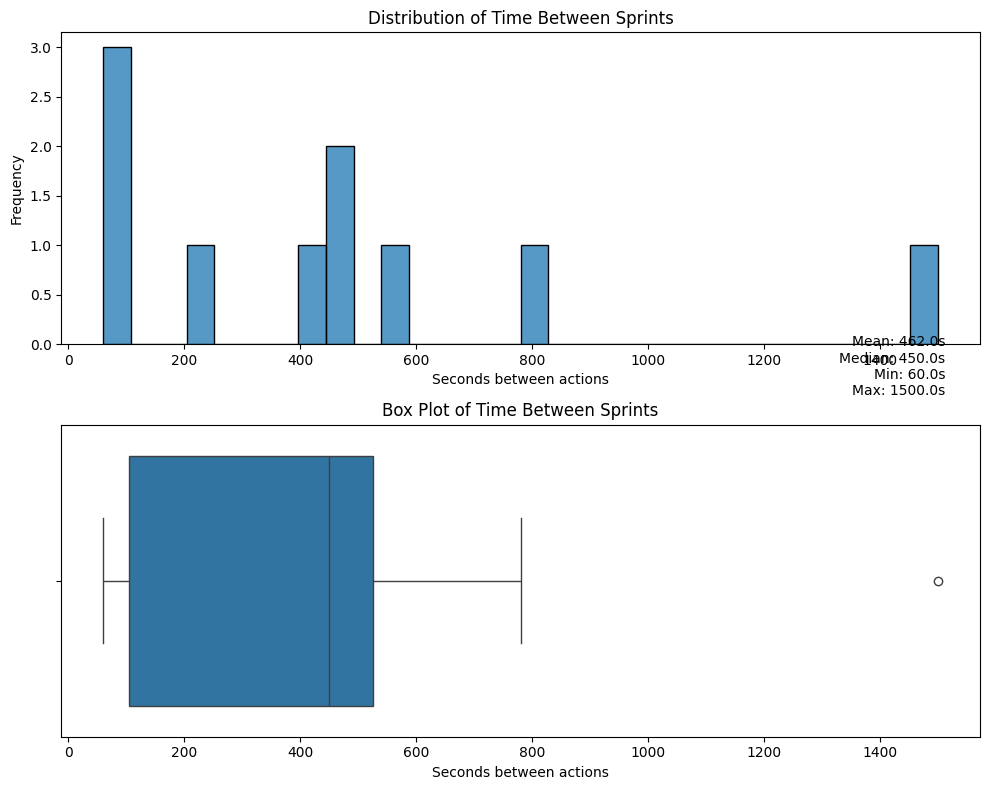

In [9]:
# Test the new plotting functionality
response = agent.chat("Plot the distribution of time between sprints")
print(response)


print(agent.last_code_generated)